# Predicting Home Prices

In [313]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.stats as stats
import math
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
  

## Project Topic
<br>
For my project I will be running a linear regression to predict house prices based on number of bedrooms, number of bathrooms, lot size, zip code, and house size. I chose this as the topic for my project because I wanted data that was both readily available and at least somewhat easy to work with. 
<br>

## Project Goal
<br>
The goal of my project is to use a very studied type of data to analyze. I want my project to be a straightforward way to learn the tools of this class while having at least some value in what the results teach us.

## The Data

The dataset I will be using is named USA Real Estate Dataset: Real Estate listings in the US broken by State and zip code. The data contains current and recent home sales listings with the basic information about the homes in question. The attributes of the dataset include price, bed, bath, acre_lot, full_address, street, city, state, zip_code, house_size, and sold_date. The data comes from a single source and is in the form of a CSV file thus is tabulated data. The original data had 613,159 rows and after the cleaning detailed below currently sits at 24,980 rows. 



In [314]:
df = pd.read_csv('realtor-data.csv')

df.head(1)

,price,bed,bath,acre_lot,full_address,street,city,state,zip_code,house_size,sold_date
0,105000,3.0,2.0,0.12,"Sector Yahuecas Titulo # V84, Adjuntas, PR, 00601",Sector Yahuecas Titulo # V84,Adjuntas,Puerto Rico,601.0,920.0,NaN


In [315]:
print("Starting size of dataset:\n", df.shape[0], "rows\n", df.shape[1], "columns")

Starting size of dataset:
 613159 rows
 11 columns


I will also be using a dataset to qualify zip codes as urban, suburban, or rural.

In [316]:
df2 = pd.read_csv('full-ZCTA-urban-suburban-rural-classification.csv')

df2.head(1)

,ZCTA,density,classification
0,1001,631,2


Sakib, A. S. (2023, July 10). *Datasets | Jed Kolko*. jedkolko. http://jedkolko.com/datasets/

Kolko, Jed (2023, Aug 10). *USA Real Estate Dataset*. Kaggle. https://www.kaggle.com/datasets/ahmedshahriarsakib/usa-real-estate-dataset 

## Initial Attributes

* price
    * Sale or listing value
* bed
    * Number of bedrooms include in the home
* bath
    * Number of bathrooms include in the home
* acre_lot
    * Size of the lot included in the listing. May be zero.
* full_address
    * Addess of listing. 
* street
    * Street name of listing.
* city
    * City name of listing.
* state
    * State name of listing.
* zip_code
    * zip code of the listing.
* house_size
    * Size of the home's interior.
* sold_date
    * Date the home was sold. 

## Data Cleaning

### Removed Duplicate entries. 

The dataset I'm using had some duplicate entries which needed to be removed to avoid affecting the results. Removing the duplicates using the Pandas method drop_duplicates results in lowering the number of rows to 81371.

In [317]:
df.drop_duplicates(inplace = True)
print("Size of dataset after removing duplicates:\n", df.shape[0], "rows\n", df.shape[1], "columns")

Size of dataset after removing duplicates:
 81371 rows
 11 columns


### Filtering the Data
I am limiting the data to current listing as well as homes with a sold_date of 2020-2022. This is to avoid large changes in home prices associated with inflation.


In [318]:
# Start by setting the data type of sold_date to datetime.
df["sold_date"] = pd.to_datetime(df["sold_date"], format='%m/%d/%Y')

# Overwrite the dataframe to contain listings with a sold_date from 2019 to 2022.
df = df[df["sold_date"].isnull() == False]
df = df[df["sold_date"] >= "2019-01-01"]

print("Size of dataset for current and newer listings:\n", df.shape[0], "rows\n", df.shape[1], "columns")

Size of dataset for current and newer listings:
 7067 rows
 11 columns


Removing "NA" from zip_code.

In [319]:
df = df[df['zip_code'].isna() == False]

print("Size of dataset for current and newer listings:\n", df.shape[0], "rows\n", df.shape[1], "columns")

Size of dataset for current and newer listings:
 7067 rows
 11 columns


### Removing Attributes

Some of the attributes in the dataframe are unneeded so they can be removed. The following attributes are to be removed:

* Address 
    * While addresses do have a real world effect on home prices the way this column is build means its usefulness for analysis is incredibly limited. As is, it is very unlikely to have any effect on home prices.
* Street
    * For the most part street names are not unique to a single city. A street named "Main" for example may be in a nice part of town, a bad part of town, or anywhere in between. This means there is likely no effect on home prices.
* City 
    * City likely does have an effect on home prices however location data is more accurately captured by the zip code. This makes both city unneeded. 
* Sold Dates
    * Initially I needed sold_date to limit the data to only include recent listings However, since I'm excluding from my model the effect of inflation on sold_date is no longer needed so it can be removed.

In [320]:
# Use the pandas drop method to remove the unneed attributes from the dataframe.
df.drop(columns = ["full_address", "street", "city", "sold_date"], inplace = True)

print("Size of dataset after dropping attributes:\n", df.shape[0], "rows\n", df.shape[1], "columns")

Size of dataset after dropping attributes:
 7067 rows
 7 columns


### Remove Empty Lots

The dataset includes empty lots. Since the goal of this project is to analyze home prices the data about these empty lots can be removed. This is achieved by filtering out the rows that have a null value for bed, bath, and house_size. It is likely that there are a few homes included in the dataset that incorrectly have null values in those three attributes but however after looking at the dataset it seems likely the number of incorrect listings will be low.

In [321]:
# Filter the dataframe using conditionals and the notnull method
df = df[(df["bed"].notnull() & df["bath"].notnull() & df["house_size"].notnull() & df["acre_lot"].notnull())]

print("Size of dataset after removing empty lots and incorrect listings:\n", df.shape[0], "rows\n", df.shape[1], "columns")

Size of dataset after removing empty lots and incorrect listings:
 3584 rows
 7 columns


### Remove Puerto Rico

To simplify the analysis I'm removing Puerto Rico so that the dataset only includes homes in the lower 48 states. This is to remove possible outliers and to simplify steps below.

In [322]:
# Filter the dataframe using conditional
df = df[df["state"] != "Puerto Rico"]

print("Size of dataset after removing Puerto Rice listings:\n", df.shape[0], "rows\n", df.shape[1], "columns")

Size of dataset after removing Puerto Rice listings:
 3583 rows
 7 columns


### Remove Outliers

In [323]:
# Use the zscore method to remove outliers from the data.
df = df[stats.zscore(df["price"]) < 2]
df = df[stats.zscore(df["bed"]) < 2]
df = df[stats.zscore(df["bath"]) < 2]
df = df[stats.zscore(df["house_size"]) < 2]
df = df[stats.zscore(df["acre_lot"]) < 2]

print("Size of dataset after removing outliers:\n", df.shape[0], "rows\n", df.shape[1], "columns")

Size of dataset after removing outliers:
 3142 rows
 7 columns


## Exploratory Data Analysis


### Visualizations

### Bedrooms
As we can see the the Bedrooms histogram has a moderate right skew. Most of the density falls within the values of 2 and 5. 

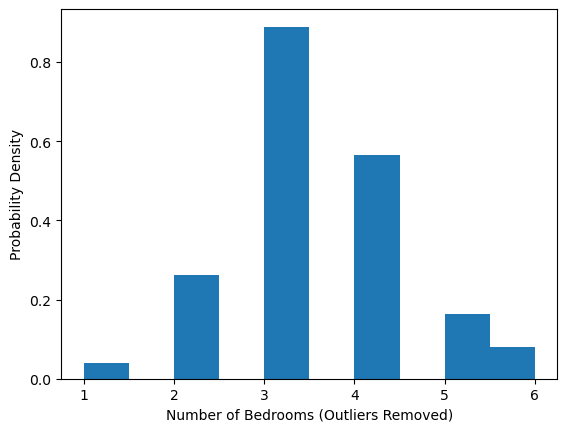

In [324]:

plt.ylabel("Probability Density")
plt.xlabel("Number of Bedrooms (Outliers Removed)")
plt.hist(df["bed"], density=True);

### Bathrooms

Here we can see the the Bathrooms histogram has more of a right skew than the Bedrooms plot. Most of the density falls within the values of 1 and 5.

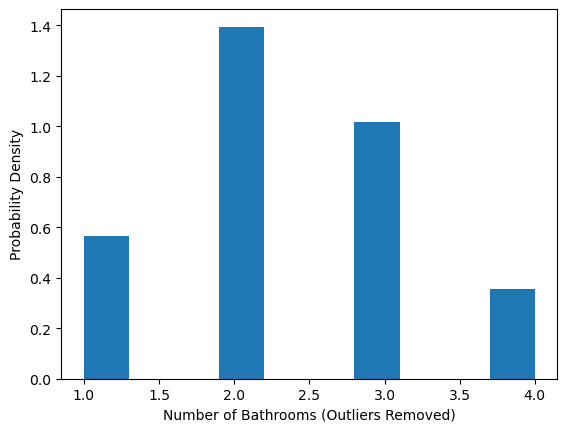

In [325]:
plt.ylabel("Probability Density")
plt.xlabel("Number of Bathrooms (Outliers Removed)")
plt.hist(df["bath"], density=True);

### Lot Size

Lot size has by far the most right skew of any plot. Most of the density falls between 0 and 1. It should be of note that many homes have a Lot Size of zero which helps lead to this extreme skew.

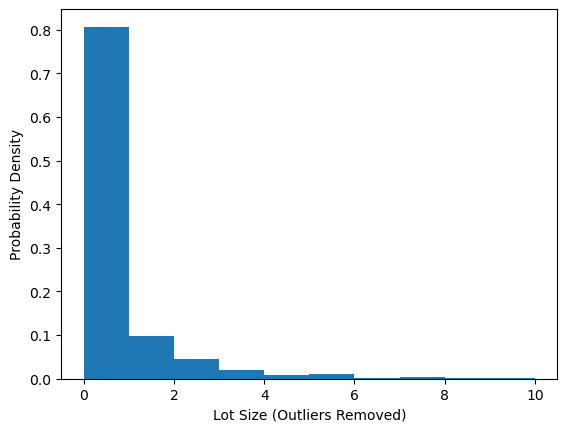

In [326]:
plt.ylabel("Probability Density")
plt.xlabel("Lot Size (Outliers Removed)")
plt.hist(df["acre_lot"], range=[0, 10], density=True);

### House Size

House Size is another attribute with a large amount of right skew. 

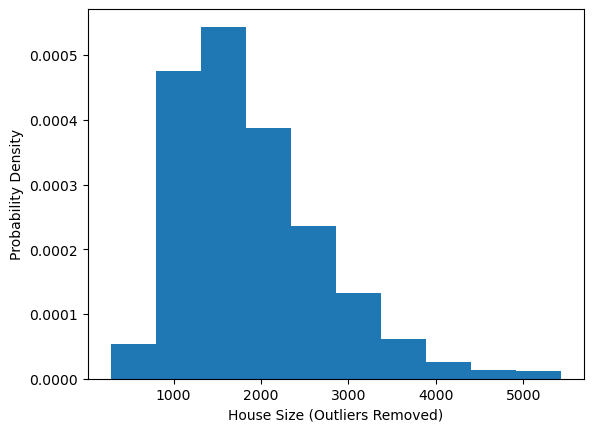

In [327]:
plt.ylabel("Probability Density")
plt.xlabel("House Size (Outliers Removed)")
plt.hist(df["house_size"], density=True);

### Price

Price is the attribute with by far the least amount of skew. It's not quite skew free so we can't say it looks like a normal distribution but it's definitely the attribute that comes closest.

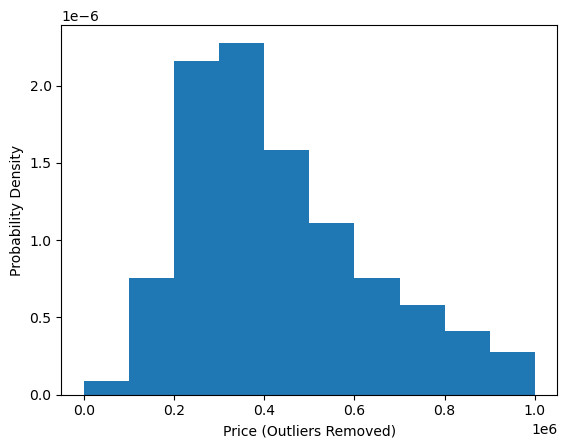

In [328]:
plt.ylabel("Probability Density")
plt.xlabel("Price (Outliers Removed)")
plt.hist(df["price"], range=[0, 1000000], density=True);

### Zip Code

There's no reason to plot zip codes as they are assigned geographically. Since the dataset doesn't include any of the west coast all we would learn is that most housing in this dataset is located towards the east coast. On top of that despite the fact that zip codes are integers in the context of a regression this data would qualify as categorical. There are a few options on how to handle this that are within the scope of this class. One would be to have each zip code be it's own dummy, the problem with this is that there would then be thousands of variables to include in the regression. A second option is to only use the first three digits of the zip code, this would still give enough location data but it still leaves hundreds of dummies that would be needed. A third option is to use the first two digits, this option would be managable however it would barely be better that using state as a categorical variable. The last option is to transform the zip code data into something more managable. To that end using ZCTA data we can use the zip codes to add a new column that shows if the house is in a rural, suburban, or urban area.

### Neighborhood Type



In [329]:

df2.rename(columns = {"ZCTA": "zip_code"}, inplace = True)
df2.drop(columns = ["density"], inplace = True)
df = df.merge(df2, on = "zip_code")

df.head(1)

,price,bed,bath,acre_lot,state,zip_code,house_size,classification
0,275000,3.0,2.0,0.16,Massachusetts,1002.0,1280.0,2


### Pair Plot

As we can see from the below pair plot there doesn't seem to be a lot of correlation between many of the attributes. The two attributes that seem to have at least some correlation is bed and bath. This makes sense as when you increase the number of bedroom in a home you also tend to see a corresponding increase in the number of bathroom. More bedrooms means more people, more people means more bathrooms are needed. The other attributes appear to have little correlation which intuitively seems somewhat unusual. I do wonder the large number of outliers is having an effect on the visual appearance of a correlation.

<Figure size 2000x1500 with 0 Axes>

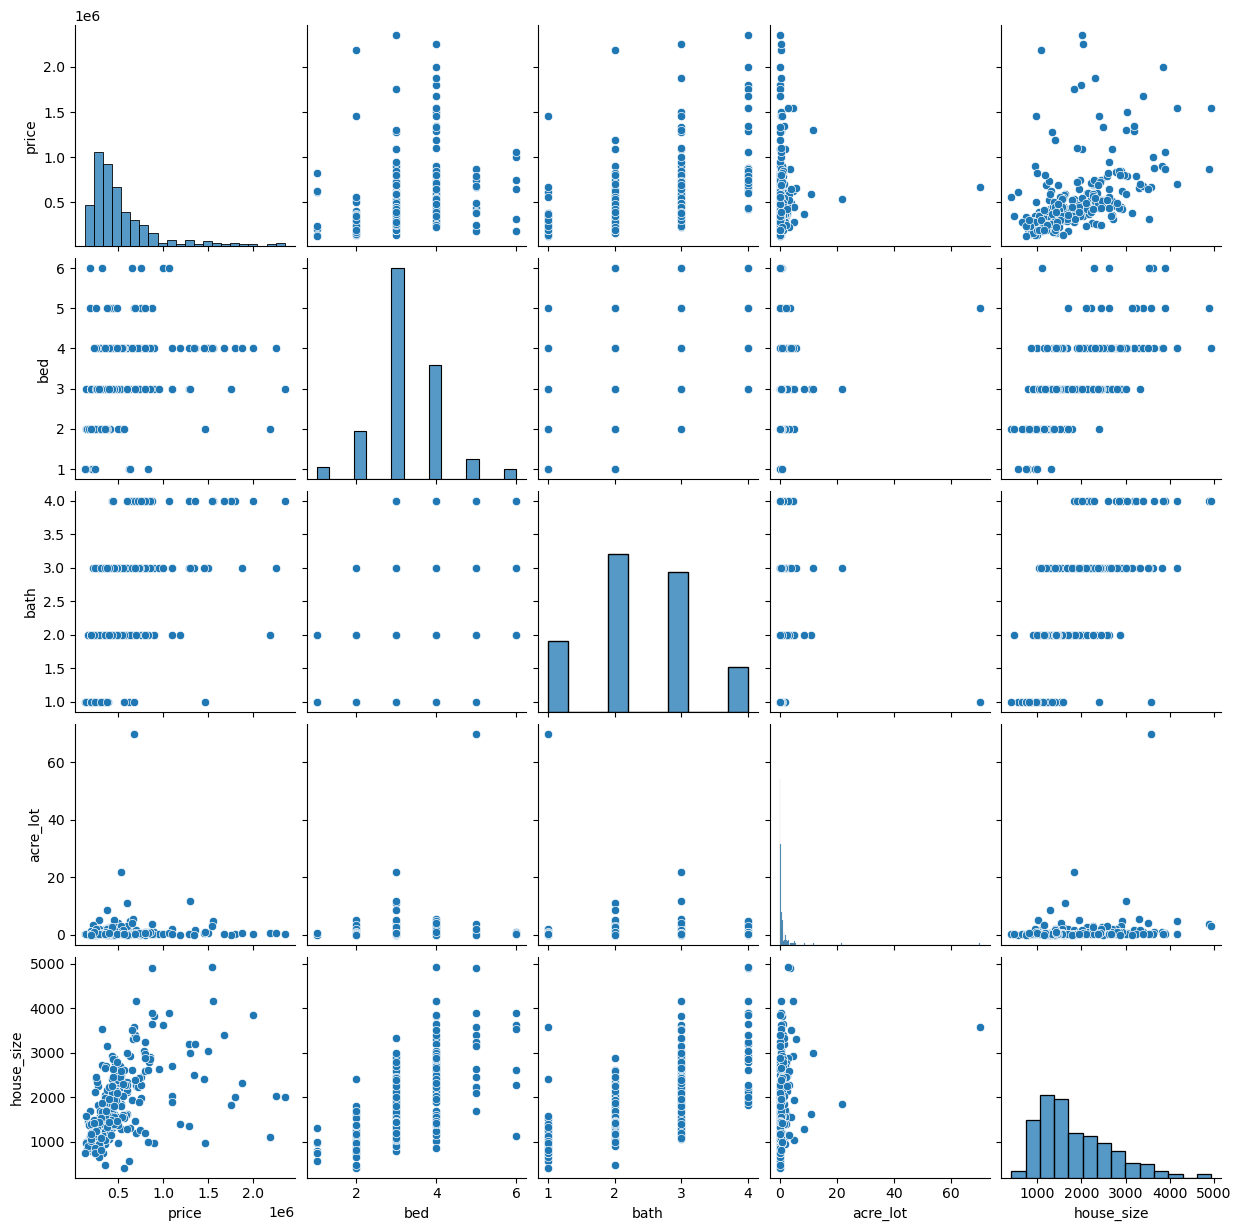

In [330]:
n = df.shape[0]
frac = 0.08
plt.figure(figsize=(20,15))
sns.pairplot(df.sample(frac=frac), vars=["price", "bed", "bath", "acre_lot", "house_size"])
plt.show()

### Looking for Colinearity

Given the fact that more rooms mean a larger house it's likely that the variables bed, bath, and house_size will have some colinearity. To test for colinearity I'm going to look at the Variance Inflation Factor. A VIF of 0 to 5 is good, 5 to 10 means that the data has colinearity but isn't terrible, and 10+ is extreme colinearity.

In [250]:
# The variable set
X = df[['bed', 'bath', 'house_size']]
  
# Make a dataframe for the VIF data
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# Calculating VIF for each attribute
vif_data["VIF"] = [vif(X.values, i) for i in range(len(X.columns))]
  
print(vif_data)

      feature        VIF
0         bed  12.132767
1        bath  14.081212
2  house_size  13.417652


As we can see the VIF for all 3 variables it above 10 this means we can't use all three variables together. This means all three variables shouldn't be used together. Now we can check the correlation between all of the combinations of the variables.

In [251]:
X = df[['bed', 'house_size']]
corr = X.corr()
  
print(corr)

                 bed  house_size
bed         1.000000    0.591856
house_size  0.591856    1.000000


In [252]:
X = df[['bath', 'house_size']]
corr = X.corr()
  
print(corr)

                bath  house_size
bath        1.000000    0.679031
house_size  0.679031    1.000000


In [253]:
X = df[['bed', 'bath']] 
corr = X.corr()
  
print(corr)

           bed      bath
bed   1.000000  0.505788
bath  0.505788  1.000000


As we can see there is strong correlation between any combination of these variables with the lowest correlation belonging to the combination of bed and bath. 

Looking at the data it seems like there are only two decent choices. Either use house_size by itself or use bed and bath without house_size. The safer choice is the former but either way I will test the both combinations.

## Initial Models

Since house_size can't be used with bed and bath we'll start by building two full models. One will be $ price = C(bath) + C(bed) + acre_lot + C(classification) $ and the other will be $ price = house\_size + acre\_lot + C(classification)$. 

In [254]:
model1 = smf.ols(formula="price~C(bath)+C(bed)+acre_lot+C(classification)", data=df).fit() 
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     121.4
Date:                Tue, 15 Aug 2023   Prob (F-statistic):          6.58e-232
Time:                        03:02:02   Log-Likelihood:                -43963.
No. Observations:                3136   AIC:                         8.795e+04
Df Residuals:                    3124   BIC:                         8.802e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                4.83e+05   3.86e+04     12.522      0.000    4.07e+05    5.59e+05
C(bath)[T.2.0]          1.102e+05   1.63e+04      6.771      0.000    7.83e+04    1.42e+05
C(bath)[T.3.0]          3.208e+05   1.83e+04     17.511      0.000    2.85e+05    3.57e+05
C(bath)[T.4.0]          6.104e+05   2.36e+04     25.897      0.000    5.64e+05    6.57e+05
C(bed)[T.2.0]           -4.63e+04   4.04e+04     -1.146      0.252   -1.25e+05    3.29e+04
C(bed)[T.3.0]           -9.58e+04   3.93e+04     -2.435      0.015   -1.73e+05   -1.87e+04
C(bed)[T.4.0]          -5.758e+04   4.07e+04     -1.413      0.158   -1.37e+05    2.23e+04
C(bed)[T.5.0]          -4.658e+04    4.4e+04     -1.059      0.290   -1.33e+05    3.97e+04
C(bed)[T.6.0]          -1.352e+05   4.78e+04     -2.830      0.005   -2.29e+05   -4.15e+04
C(classification)[T.2] -1.118e+05   1.46e+04     -7.646      0.000    -1.4e+05   -8.31e+04
C(classification)[T.3] -1.897e+05   1.83e+04    -10.373      0.000   -2.26e+05   -1.54e+05
acre_lot                3561.1143    751.682      4.738      0.000    2087.274    5034.954
==============================================================================
Omnibus:                     1655.909   Durbin-Watson:                   1.131
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14277.755
Skew:                           2.369   Prob(JB):                         0.00
Kurtosis:                      12.318   Cond. No.                         132.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [255]:
model2 = smf.ols(formula="price~house_size+acre_lot+C(classification)", data=df).fit() 
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     260.1
Date:                Tue, 15 Aug 2023   Prob (F-statistic):          3.34e-193
Time:                        03:02:03   Log-Likelihood:                -44071.
No. Observations:                3136   AIC:                         8.815e+04
Df Residuals:                    3131   BIC:                         8.818e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               2.608e+05   1.76e+04     14.777      0.000    2.26e+05    2.95e+05
C(classification)[T.2] -1.257e+05   1.49e+04     -8.443      0.000   -1.55e+05   -9.65e+04
C(classification)[T.3] -2.459e+05   1.87e+04    -13.128      0.000   -2.83e+05   -2.09e+05
house_size               199.7827      6.699     29.821      0.000     186.647     212.918
acre_lot                2659.7768    780.944      3.406      0.001    1128.562    4190.992
==============================================================================
Omnibus:                     1712.753   Durbin-Watson:                   0.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15927.743
Skew:                           2.445   Prob(JB):                         0.00
Kurtosis:                      12.899   Cond. No.                     9.45e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.45e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Drill Down

As you can see the result so far aren't very encouraging. Model 1 has an $r^2$ of $0.300$ and model 2 has an $r^2$ of $0.249$ which are both pretty darn low. Perhaps since this dataset includes many different states which may have an affect on the price of housing. It's worth drilling down and trying this one of these models on some individual states.

In [262]:
penn = df[df["state"] == "Pennsylvania"]
model1_penn = smf.ols(formula="price~C(bath)+C(bed)+acre_lot+C(classification)", data=penn).fit() 
model1_penn.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     9.219
Date:                Tue, 15 Aug 2023   Prob (F-statistic):           1.58e-10
Time:                        03:04:50   Log-Likelihood:                -1373.4
No. Observations:                 107   AIC:                             2769.
Df Residuals:                      96   BIC:                             2798.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               2.064e+05   6.15e+04      3.354      0.001    8.42e+04    3.28e+05
C(bath)[T.2.0]          1.201e+05   4.02e+04      2.990      0.004    4.04e+04       2e+05
C(bath)[T.3.0]          2.029e+05   5.01e+04      4.050      0.000    1.03e+05    3.02e+05
C(bath)[T.4.0]          3.248e+05   7.19e+04      4.516      0.000    1.82e+05    4.68e+05
C(bed)[T.2.0]          -1.854e+04   6.07e+04     -0.305      0.761   -1.39e+05    1.02e+05
C(bed)[T.3.0]          -5.864e+04   6.94e+04     -0.844      0.401   -1.96e+05    7.92e+04
C(bed)[T.4.0]          -5.058e+04   7.55e+04     -0.670      0.505   -2.01e+05    9.94e+04
C(bed)[T.5.0]          -1.377e+04   8.73e+04     -0.158      0.875   -1.87e+05    1.59e+05
C(bed)[T.6.0]           6.973e+04   1.04e+05      0.671      0.504   -1.37e+05    2.76e+05
C(classification)[T.3] -2.423e+04    2.7e+04     -0.896      0.373   -7.79e+04    2.95e+04
acre_lot                2.859e+04   6568.961      4.352      0.000    1.56e+04    4.16e+04
==============================================================================
Omnibus:                       45.479   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              182.509
Skew:                           1.369   Prob(JB):                     2.34e-40
Kurtosis:                       8.783   Cond. No.                         36.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [263]:
dela = df[df["state"] == "Delaware"]
model1_dela = smf.ols(formula="price~C(bath)+C(bed)+acre_lot+C(classification)", data=dela).fit() 
model1_dela.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     16.76
Date:                Tue, 15 Aug 2023   Prob (F-statistic):           2.39e-09
Time:                        03:04:51   Log-Likelihood:                -512.52
No. Observations:                  42   AIC:                             1041.
Df Residuals:                      34   BIC:                             1055.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               1.649e+05   3.93e+04      4.195      0.000     8.5e+04    2.45e+05
C(bath)[T.2.0]          2.031e+04   2.37e+04      0.858      0.397   -2.78e+04    6.84e+04
C(bath)[T.3.0]          1.151e+05    2.8e+04      4.117      0.000    5.83e+04    1.72e+05
C(bath)[T.4.0]          4.203e+05   6.22e+04      6.758      0.000    2.94e+05    5.47e+05
C(bed)[T.3.0]          -2.436e+04   4.37e+04     -0.557      0.581   -1.13e+05    6.45e+04
C(bed)[T.4.0]           1241.8766   4.64e+04      0.027      0.979    -9.3e+04    9.55e+04
C(classification)[T.2]  4.384e+04   2.56e+04      1.710      0.096   -8260.576    9.59e+04
acre_lot                3.123e+05    1.3e+05      2.406      0.022    4.85e+04    5.76e+05
==============================================================================
Omnibus:                        4.603   Durbin-Watson:                   1.634
Prob(Omnibus):                  0.100   Jarque-Bera (JB):                3.849
Skew:                          -0.380   Prob(JB):                        0.146
Kurtosis:                       4.274   Cond. No.                         25.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [264]:
ver = df[df["state"] == "Vermont"]
model1_ver = smf.ols(formula="price~C(bath)+C(bed)+acre_lot+C(classification)", data=ver).fit() 
model1_ver.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     15.75
Date:                Tue, 15 Aug 2023   Prob (F-statistic):           1.20e-15
Time:                        03:04:51   Log-Likelihood:                -1301.8
No. Observations:                  97   AIC:                             2626.
Df Residuals:                      86   BIC:                             2654.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               2.145e+05   1.82e+05      1.180      0.241   -1.47e+05    5.76e+05
C(bath)[T.2.0]          1.328e+05   5.32e+04      2.498      0.014    2.71e+04    2.39e+05
C(bath)[T.3.0]           3.38e+05      6e+04      5.633      0.000    2.19e+05    4.57e+05
C(bath)[T.4.0]          3.955e+05   8.79e+04      4.498      0.000    2.21e+05     5.7e+05
C(bed)[T.2.0]          -1.021e+05   1.79e+05     -0.571      0.570   -4.58e+05    2.54e+05
C(bed)[T.3.0]          -4.182e+04   1.79e+05     -0.233      0.816   -3.98e+05    3.15e+05
C(bed)[T.4.0]          -6.308e+04   1.85e+05     -0.342      0.734    -4.3e+05    3.04e+05
C(bed)[T.5.0]          -4.633e+04   1.88e+05     -0.246      0.806    -4.2e+05    3.28e+05
C(bed)[T.6.0]          -1.388e+05   2.12e+05     -0.656      0.514    -5.6e+05    2.82e+05
C(classification)[T.3]  1.333e+04   5.58e+04      0.239      0.812   -9.76e+04    1.24e+05
acre_lot                3921.4701    597.160      6.567      0.000    2734.356    5108.585
==============================================================================
Omnibus:                       26.832   Durbin-Watson:                   1.701
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.971
Skew:                           1.102   Prob(JB):                     1.41e-11
Kurtosis:                       5.740   Cond. No.                         879.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [265]:
mass = df[df["state"] == "Massachusetts"]
model1_mass = smf.ols(formula="price~C(bath)+C(bed)+acre_lot+C(classification)", data=mass).fit() 
model1_mass.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.443
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                     7.748
Date:                Tue, 15 Aug 2023   Prob (F-statistic):           1.00e-09
Time:                        03:04:52   Log-Likelihood:                -1706.0
No. Observations:                 119   AIC:                             3436.
Df Residuals:                     107   BIC:                             3469.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               5.086e+05   1.33e+05      3.822      0.000    2.45e+05    7.72e+05
C(bath)[T.2.0]           2.87e+05    1.1e+05      2.603      0.011    6.85e+04    5.06e+05
C(bath)[T.3.0]          8.042e+05   1.46e+05      5.504      0.000    5.15e+05    1.09e+06
C(bath)[T.4.0]          1.254e+06   1.84e+05      6.806      0.000    8.89e+05    1.62e+06
C(bed)[T.2.0]           9.584e+04    1.6e+05      0.598      0.551   -2.22e+05    4.14e+05
C(bed)[T.3.0]          -2.339e+05    1.7e+05     -1.379      0.171    -5.7e+05    1.02e+05
C(bed)[T.4.0]          -3.275e+04   1.97e+05     -0.166      0.868   -4.23e+05    3.58e+05
C(bed)[T.5.0]          -1.505e+05   2.73e+05     -0.551      0.583   -6.92e+05    3.91e+05
C(bed)[T.6.0]          -8.558e+05   3.56e+05     -2.401      0.018   -1.56e+06   -1.49e+05
C(classification)[T.2]  -1.24e+05   9.69e+04     -1.280      0.203   -3.16e+05     6.8e+04
C(classification)[T.3]  3.216e+04   1.57e+05      0.205      0.838   -2.78e+05    3.43e+05
acre_lot               -1.383e+04   7697.589     -1.797      0.075   -2.91e+04    1427.739
==============================================================================
Omnibus:                       29.603   Durbin-Watson:                   1.524
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.298
Skew:                           1.065   Prob(JB):                     9.82e-13
Kurtosis:                       5.573   Cond. No.                         64.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As you can see testing these four individual states the results are improved. The $r^2$ for Vermont is $0.744$ which is a huge improvement from the initial results.

### The Return of the Zip Code

During the initial set up where the model was going to use all the states using zip codes wasn't going to be an option as there were just too many of them. This meant that clustering them in a useable way also meant losing all of the value in the model. Looking at an individual state might just allow zip codes to be brought back. They will still have to be clustered as even in individual states there are too many to be used as categorical data. This clustering can be done be using the first three digits of the zip code.

In [268]:
mass_test = mass
mass_test["zip_reduce"] = mass_test["zip_code"].map(lambda x: x - x%100)
model1_mass_test = smf.ols(formula="price~C(bath)+C(bed)+acre_lot+C(zip_reduce)", data=mass_test).fit() 
model1_mass_test.summary()


/tmp/ipykernel_231/2657450456.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mass_test["zip_reduce"] = mass_test["zip_code"].map(lambda x: x - x%100)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     10.01
Date:                Tue, 15 Aug 2023   Prob (F-statistic):           8.51e-17
Time:                        03:14:12   Log-Likelihood:                -1665.4
No. Observations:                 119   AIC:                             3381.
Df Residuals:                      94   BIC:                             3450.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 1.03e+04   1.23e+05      0.084      0.933   -2.33e+05    2.54e+05
C(bath)[T.2.0]           2.069e+05   9.22e+04      2.243      0.027    2.38e+04     3.9e+05
C(bath)[T.3.0]           5.222e+05   1.17e+05      4.453      0.000    2.89e+05    7.55e+05
C(bath)[T.4.0]           7.822e+05   1.64e+05      4.761      0.000    4.56e+05    1.11e+06
C(bed)[T.2.0]            3.114e+04   1.24e+05      0.251      0.802   -2.15e+05    2.77e+05
C(bed)[T.3.0]           -1917.0626    1.4e+05     -0.014      0.989    -2.8e+05    2.76e+05
C(bed)[T.4.0]            2.209e+05   1.57e+05      1.410      0.162   -9.02e+04    5.32e+05
C(bed)[T.5.0]            1.761e+05   2.25e+05      0.782      0.436   -2.71e+05    6.23e+05
C(bed)[T.6.0]           -2.071e+05    2.9e+05     -0.714      0.477   -7.83e+05    3.69e+05
C(zip_reduce)[T.1100.0]  7.116e+04   1.55e+05      0.460      0.647   -2.36e+05    3.79e+05
C(zip_reduce)[T.1200.0]  5.092e+05   3.47e+05      1.468      0.145   -1.79e+05     1.2e+06
C(zip_reduce)[T.1500.0]  1.198e+05   2.21e+05      0.542      0.589   -3.19e+05    5.59e+05
C(zip_reduce)[T.1600.0]  8.175e+04   3.46e+05      0.236      0.814   -6.05e+05    7.68e+05
C(zip_reduce)[T.1700.0]  3.527e+05   3.65e+05      0.965      0.337   -3.73e+05    1.08e+06
C(zip_reduce)[T.1800.0]  3.327e+05   2.16e+05      1.538      0.127   -9.68e+04    7.62e+05
C(zip_reduce)[T.1900.0]  4.676e+05   1.33e+05      3.504      0.001    2.03e+05    7.33e+05
C(zip_reduce)[T.2000.0]  2.017e+05   1.53e+05      1.317      0.191   -1.02e+05    5.06e+05
C(zip_reduce)[T.2100.0]  5.619e+05   1.18e+05      4.782      0.000    3.29e+05    7.95e+05
C(zip_reduce)[T.2200.0]  1.643e+06   2.61e+05      6.296      0.000    1.12e+06    2.16e+06
C(zip_reduce)[T.2300.0]  2.803e+05   2.04e+05      1.373      0.173   -1.25e+05    6.86e+05
C(zip_reduce)[T.2400.0]  6.844e+05    1.6e+05      4.278      0.000    3.67e+05       1e+06
C(zip_reduce)[T.2500.0]   9.47e+05   1.19e+05      7.982      0.000    7.11e+05    1.18e+06
C(zip_reduce)[T.2600.0]  4.799e+05   1.34e+05      3.568      0.001    2.13e+05    7.47e+05
C(zip_reduce)[T.2700.0]  4.946e+05   2.44e+05      2.024      0.046    9362.721     9.8e+05
acre_lot                -2273.5257   7358.445     -0.309      0.758   -1.69e+04    1.23e+04
==============================================================================
Omnibus:                       26.674   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              124.191
Skew:                           0.562   Prob(JB):                     1.08e-27
Kurtosis:                       7.877   Cond. No.                         84.7
==============================================================================

Notes:
[1] Standard Errors assum

Looking at this new model for the state of Massachusetts the $r^2$ has improved by quite a bit. The $r^2$ and $adj\_r^2$ improved by $0.276$ and $0.261$ respectively. The $r^2$ of $0.719$ means there is a fairly strong effect size displayed by this model.

### Let's Predict Something

Now that we have a decent model for home prices in Massachusetts we can use said model to predict the prices of homes. I picked some homes from the dataset, they weren't exactly randomly picked but I picked them based off of only a list of the index values.

In [288]:
yhat = model1_mass_test.predict(mass)
print("Predicted home value:", yhat[4])
print("Actual home value:", mass["price"].loc[[4]].values[0])
print("Difference:", yhat[4] - mass["price"].loc[[4]].values[0])

Predicted home value: 437745.62601592
Actual home value: 375000
Difference: 62745.62601592002


In [295]:
yhat = model1_mass_test.predict(mass)
print("Predicted home value:", yhat[27])
print("Actual home value:", mass["price"].loc[[27]].values[0])
print("Difference:", yhat[27] - mass["price"].loc[[27]].values[0])

Predicted home value: 214521.90203388146
Actual home value: 299413
Difference: -84891.09796611854


In [296]:
yhat = model1_mass_test.predict(mass)
print("Predicted home value:", yhat[295])
print("Actual home value:", mass["price"].loc[[295]].values[0])
print("Difference:", yhat[295] - mass["price"].loc[[295]].values[0])

Predicted home value: 549999.9999999992
Actual home value: 550000
Difference: -8.149072527885437e-10


In [297]:
yhat = model1_mass_test.predict(mass)
print("Predicted home value:", yhat[515])
print("Actual home value:", mass["price"].loc[[515]].values[0])
print("Difference:", yhat[515] - mass["price"].loc[[515]].values[0])

Predicted home value: 1364999.9999999972
Actual home value: 1365000
Difference: -2.7939677238464355e-09


In [299]:
yhat = model1_mass_test.predict(mass)
print("Predicted home value:", yhat[863])
print("Actual home value:", mass["price"].loc[[863]].values[0])
print("Difference:", yhat[863] - mass["price"].loc[[863]].values[0])

Predicted home value: 769938.3351230803
Actual home value: 719900
Difference: 50038.335123080295


In [300]:
yhat = model1_mass_test.predict(mass)
print("Predicted home value:", yhat[946])
print("Actual home value:", mass["price"].loc[[946]].values[0])
print("Difference:", yhat[946] - mass["price"].loc[[946]].values[0])

Predicted home value: 520760.12361177587
Actual home value: 499000
Difference: 21760.123611775867


## Conclusions

- Location plays a noticable role in home value. Before the zip code data could be brought back into the model the model's effectiveness wasn't looking too good. The $r^2$ increase by $0.276$ when the clustered zip code data was used in the model.
- House statistics are strongly correlated. The result of the VIF speaks for itself, there was a large amount of colinearity. I mitigated this somewhat by removing house_size from the model however there is probably more correlation between variable than is ideal. 
- Predicting home values with a model like this can give oddly close predictions as well as wildly incorrect predictions. Two of the predicted values were all but exactly correct where as another prediction was off by almost $85,000.